## Project Submission

Please fill out:
* Student name: Daniel Bradley and Monica Haderthauer
* Student pace: full time
* Scheduled project review date/time: 03/31/2022
* Instructor name: Praveen Gowtham
* Blog post URL: https://github.com/DanlBradley/Phase2Project


In [2]:
# Your code here - remember to use markdown cells for comments as well!
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

In [3]:
def money_str_to_float(x):
    if type(x) == str:
        x = x.replace('$','')
        x = x.replace(',','')
        return float(x)
    elif type(x) == int:
        return float(x)

## Initial inspection and cleaning
- Clean up DataFrame, drop NaN entries if there is sufficient data, and look for NaN entries that go under a placeholder name
- Split DataFrame into numerics and categorical variables
- Basic feature engineering such as 'price / sqfoot' column and 'renovated vs. not renovated' column

In [4]:
#Create housing dataframe
df = pd.read_csv('data/kc_house_data.csv')

#Remove outliers (95th percentile)
df = df.drop(labels = df.loc[df['price'] >= 1160000.0].index, axis = 0)
df = df.drop(labels = df.loc[df['bedrooms'] >= 5.0].index, axis = 0)
#Clean up NaNs
df['sqft_basement'] = df['sqft_basement'].replace('?',np.nan)
df.drop(columns = 'sqft_lot15')
df = df.dropna()


#Convert date string to datetime
df['date'] = pd.to_datetime(df['date'])


#Convert sqft_basement to a float
df['sqft_basement'] = df['sqft_basement'].apply(lambda x: float(x))


#Add categorical column "renovated" vs "not renovated"
df['renovated_status'] = df['yr_renovated'].apply(lambda x: 'NO' if x == 0 else 'YES')


#Add a price / sqfoot column
df['price_per_sqfoot'] = df['price'] / df['sqft_above']

In [5]:
#Create dataframe for just numerics
df_numerics = df.select_dtypes(include = np.number, exclude = object)

#Select a target metric to compare other columns to
target_metric = 'price'

In [6]:
#Create a categorical dataframe
df_cat = df[['waterfront','view','condition','grade','renovated_status']]

In [7]:
#Make a multiple linear regression model to check parameters performance on predicting target metric (chosen above in cell 3)
y = df_numerics[target_metric]
x = sm.add_constant(df_numerics.drop(columns=[target_metric,'id','yr_renovated','zipcode','sqft_lot15']))
model = sm.OLS(y,x).fit()
model.summary();

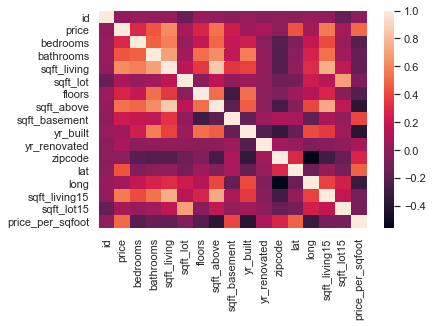

In [8]:
#Correlation matrix
Var_Corr = df_numerics.corr()
# plot the heatmap and annotation on it
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=False);

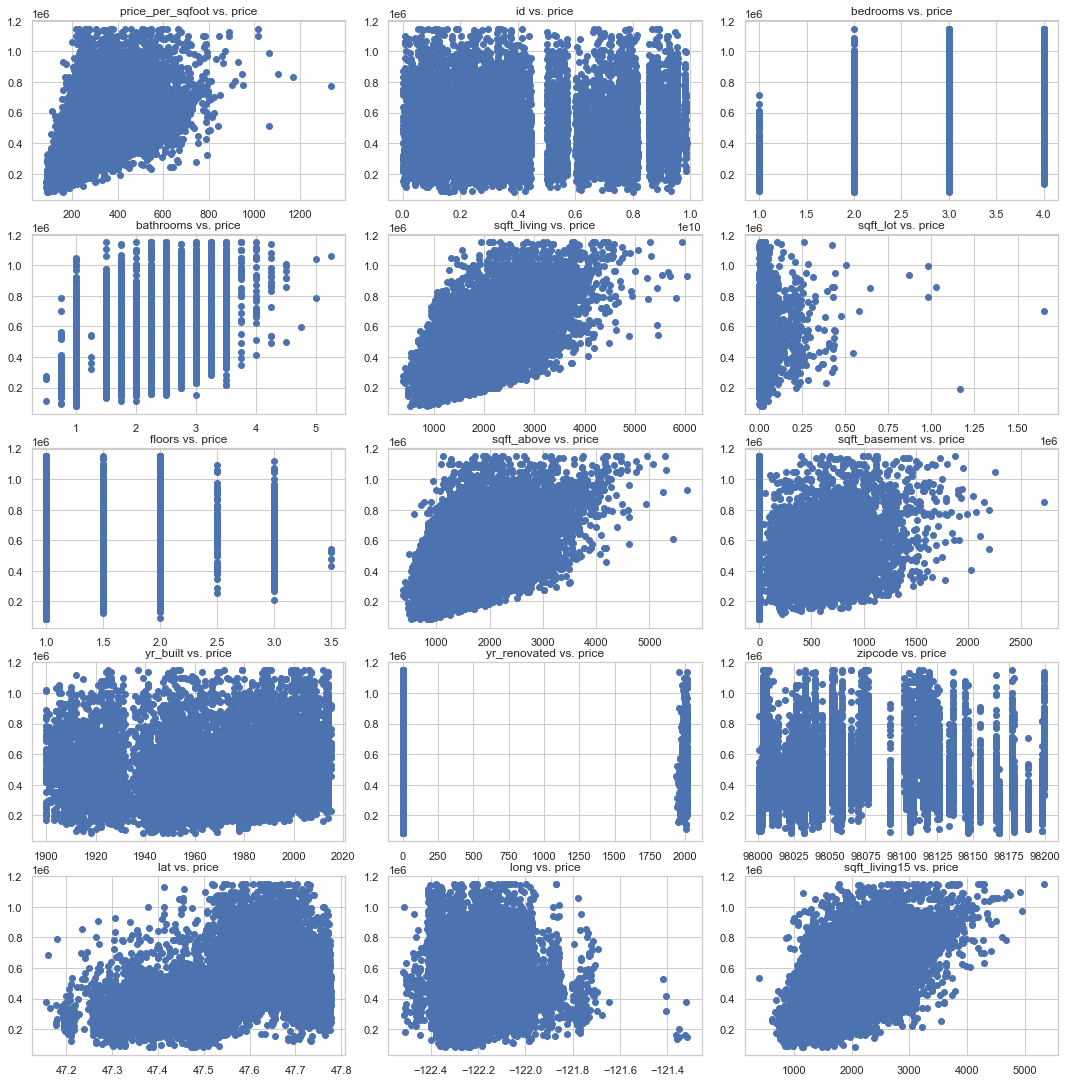

In [9]:
fig, axs = plt.subplots(5,3)

fig.set_figheight(15)
fig.set_figwidth(15)
plt.tight_layout()
independants = df_numerics.drop(columns=target_metric)
dependant = df_numerics[target_metric]
column_num = 0

for i in range(5):
    for j in range(3):
        axs[i,j].scatter(independants.iloc[:,(column_num-1)],dependant)
        axs[i,j].set_title('{} vs. {}'.format(independants.columns[column_num-1], target_metric))
        column_num += 1

In [10]:
import folium
df_renovated = df_numerics.loc[df_numerics['yr_renovated'] != 0]
lat = df_renovated['lat']
long = df_renovated['long']

#Create a map of the area
base_map = folium.Map([lat.mean(), long.mean()], zoom_start=13)

for lat1,long1 in zip(lat,long):
     popup_text = 'Lat: {} \n Long: {}'.format(lat1,long1)
     popup = folium.Popup(popup_text, parse_html=True)
     marker = folium.Marker(location=[lat1, long1], popup = popup)
     marker.add_to(base_map)
     
base_map;


## Combining seattle AirBNB data with seattle housing data 
- Determine a predictive model for homes doing well in airbnb vs. the housing data
- Then make inferences about what to look for in a home when buying as an AirBNB investment

In [48]:
bnb_listings = pd.read_csv('data/earnings_data.csv')
# bnb_listings['price'].fillna(0, inplace=True)
# bnb_listings['price'] = bnb_listings['price'].apply(lambda x: money_str_to_float(x))  

#Function to remove outliers of a chosen percentile
def outliers(column, n = .95):
    quan = column.quantile(n)
    outliers = column.loc[column >= quan].index
    return outliers

def lower_outliers(column, n = .95):
    quan = column.quantile(n)
    outliers = column.loc[column <= quan].index
    return outliers

In [12]:
#This cell drops selected outliers
df_columns = ['host_listings_count', 'price', 'minimum_nights']
drop = []
for each_column in df_columns:
    remove = list(outliers(bnb_listings[each_column],0.99))
    for item in remove:
        drop.append(item)
len(set(drop))
bnb_listings = bnb_listings.drop(labels = (np.array(drop)),axis = 0)

In [13]:
#bnb_listings = pd.read_csv('data/earnings_data.csv')
n=3
#Renaming columns so they can be merged properly
bnb_listings['long'] = round(bnb_listings['longitude'],n)
df['long'] = round(df['long'],n)
bnb_listings['lat'] = round(bnb_listings['latitude'],n)
df['lat'] = round(df['lat'],n)

In [14]:
merged = df.merge(bnb_listings, how = 'inner', on = ['long','lat'])

In [15]:
lat = merged['lat'] #Folium map
long = merged['long']

#Create a map of the area
base_map = folium.Map([lat.mean(), long.mean()], zoom_start=12)

for lat1,long1 in zip(lat,long):
     popup_text = 'Lat: {} \n Long: {}'.format(lat1,long1)
     popup = folium.Popup(popup_text, parse_html=True)
     marker = folium.Marker(location=[lat1, long1], popup = popup)
     marker.add_to(base_map)
     
base_map;

In [16]:
#Look at numerical columns
merged_numerics = merged.select_dtypes(include = np.number, exclude = object)
merged_numerics = merged_numerics.dropna()

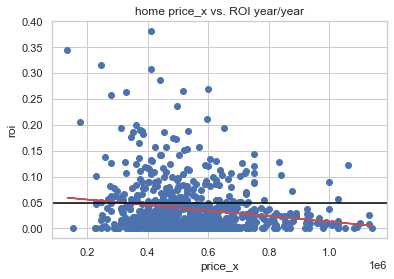

In [17]:
# #Parameterized cell to let you scatter two variables from merged_numerics

#roi is a feature that lets you measure the performance of an airbnb listing. A common benchmark is 5% ROI.
merged_numerics['roi'] = (merged_numerics['earnings_per_mo'] * 12) / merged_numerics['price_x']
#merged_numerics = merged_numerics.drop(columns = 'avg_earnings')
fig, ax = plt.subplots()
x = merged_numerics['price_x']
y = merged_numerics['roi']
m,b = np.polyfit(x = x, y = y, deg = 1)
plt.scatter(x,y)
plt.xlabel(x.name)
plt.ylabel(y.name)
plt.title('home {} vs. ROI year/year'.format(x.name))
plt.plot(x,x*m+b, c= 'r')
plt.axhline(.05, c = 'black');

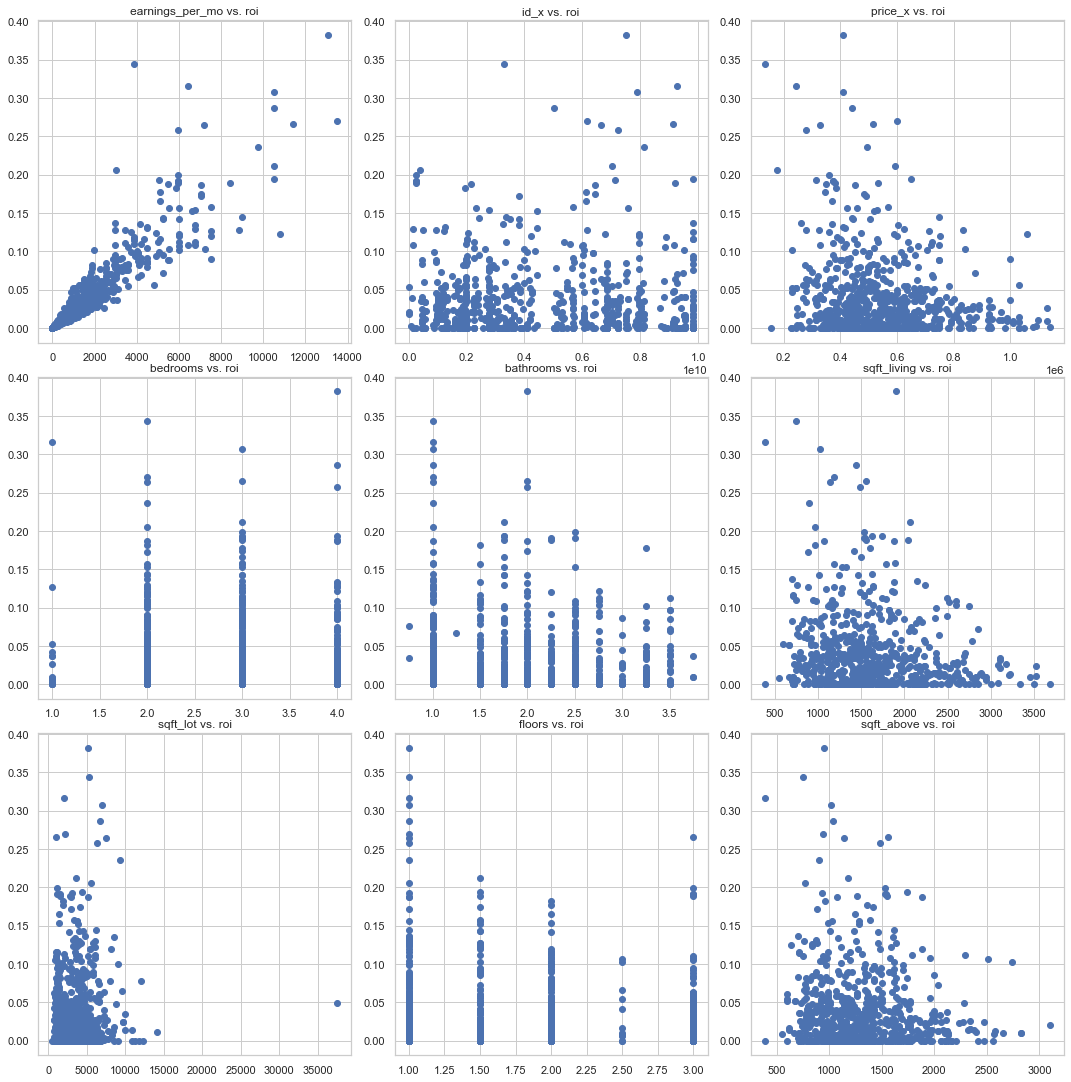

In [18]:
fig, axs = plt.subplots(3,3)
bnb_metric = 'roi'
fig.set_figheight(15)
fig.set_figwidth(15)
plt.tight_layout()
independants = merged_numerics.drop(columns=bnb_metric)
dependant = merged_numerics[bnb_metric]
column_num = 0

for i in range(3):
    for j in range(3):
        axs[i,j].scatter(independants.iloc[:,(column_num-1)],dependant)
        axs[i,j].set_title('{} vs. {}'.format(independants.columns[column_num-1], bnb_metric))
        column_num += 1
        

## Interpret results above
I view the results above as showing that the combination of reviews

In [19]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 755 entries, 0 to 754
Data columns (total 62 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   id_x                          755 non-null    int64         
 1   date                          755 non-null    datetime64[ns]
 2   price_x                       755 non-null    float64       
 3   bedrooms                      755 non-null    int64         
 4   bathrooms                     755 non-null    float64       
 5   sqft_living                   755 non-null    int64         
 6   sqft_lot                      755 non-null    int64         
 7   floors                        755 non-null    float64       
 8   waterfront                    755 non-null    object        
 9   view                          755 non-null    object        
 10  condition                     755 non-null    object        
 11  grade                         75

In [20]:
keep_list = [
 'price_x',
 'zipcode_x',
 'bedrooms',
 'bathrooms',
 'host_listings_count',
 'neighbourhood_cleansed',
 'property_type',
 'room_type',
 'accommodates',
 'price_y',
 'guests_included',
 'minimum_nights',
 'maximum_nights',
 'availability_30',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_communication',
 'review_scores_location',
 'reviews_per_month']

airbnb_training_set = merged[keep_list]
#airbnb_training_set.drop(columns = 'price_y',inplace=True)
#airbnb_training_set = airbnb_training_set.dropna()
#airbnb_training_set.iloc[:,:20].info()
airbnb_training_set.shape

(755, 21)

In [21]:
#airbnb_training_set.shape
airbnb_training_set.rename(columns = {'price_y': 'price'}, inplace = True)
airbnb_training_set.rename(columns = {'zipcode_x': 'zipcode'}, inplace = True)

/Users/monicahaderthauer/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [22]:
zip_kc = df['zipcode'].unique()
bnb_listings = bnb_listings.loc[bnb_listings['zipcode'] != '99\r\n98122']
zip_bnb = bnb_listings['zipcode'].astype(int).unique()

def common_member(a, b):
    a_set = set(a)
    b_set = set(b)
 
    if (a_set & b_set):
        return a_set & b_set
    else:
        print("No common elements")

new_set = common_member(zip_bnb,zip_kc)

In [23]:
airbnb_training_set = airbnb_training_set.loc[airbnb_training_set['zipcode'].isin(new_set)]
airbnb_training_set['zipcode'] = airbnb_training_set['zipcode'].astype('category')

In [24]:
nominal_cols = ['zipcode', 'property_type','room_type','neighbourhood_cleansed']
airbnb_training_set_model = pd.get_dummies(airbnb_training_set,columns=nominal_cols,drop_first=True)
airbnb_training_set_model.shape

(755, 117)

In [25]:
y = airbnb_training_set_model['price_x']
X = airbnb_training_set_model.drop(columns = 'price_x')
lr = LinearRegression()

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
MAE = round(mean_absolute_error(y_pred, y_test),2)
score = round(lr.score(X_train, y_train),2)
print('R^2 value: {}, absolute mean error: {}'.format(score,MAE))

R^2 value: 0.59, absolute mean error: 102047.56


(array([ 1., 11., 10., 22., 33., 38., 21., 10.,  3.,  2.]),
 array([157537.24507516, 240241.84359325, 322946.44211133, 405651.04062942,
        488355.63914751, 571060.2376656 , 653764.83618369, 736469.43470178,
        819174.03321987, 901878.63173796, 984583.23025605]),
 <BarContainer object of 10 artists>)

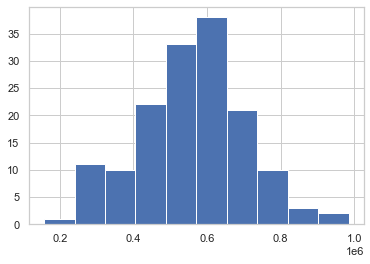

In [27]:
plt.hist(y_pred)

In [28]:
X.shape

(755, 116)

In [29]:
# #Correlation matrix
# Var_Corr = airbnb_training_set.corr()
# # plot the heatmap and annotation on it
# sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=False);

In [30]:
def generate_collinearity_pairs(x):

    # save absolute value of correlation matrix as a data frame
    # converts all values to absolute value
    # stacks the row:column pairs into a multindex
    # reset the index to set the multindex to seperate columns
    # sort values. 0 is the column automatically generated by the stacking

    df=x.corr().abs().stack().reset_index().sort_values(0, ascending=False)

    # zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
    df['pairs'] = list(zip(df.level_0, df.level_1))

    # set index to pairs
    df.set_index(['pairs'], inplace = True)

    #d rop level columns
    df.drop(columns=['level_1', 'level_0'], inplace = True)

    # rename correlation column as cc rather than 0
    df.columns = ['cc']

    # drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
    # for the sake of exercise, kept it in.
    df.drop_duplicates(inplace=True)

    return df

In [31]:
# df = generate_collinearity_pairs(airbnb_training_set)

# #drop a variable from each highly collinear pair
# df[(df.cc>.50) & (df.cc <1)]

# #used this cell to drop review_scores_checkin, earnings_per_mo, review_scores_value, review_scores_checkin

## now import airbnb listings to generate synthetic mortgage data

In [90]:
bnb_listings_full = pd.read_csv('data/listings.csv')

In [91]:
synthetic_mortgages_df = bnb_listings_full[[
 'zipcode',
 'bedrooms',
 'bathrooms',
 'host_listings_count',
 'neighbourhood_cleansed',
 'property_type',
 'room_type',
 'accommodates',
 'price',
 'guests_included',
 'minimum_nights',
 'maximum_nights',
 'availability_30',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_communication',
 'review_scores_location',
 'reviews_per_month'
 ]];

In [92]:
synthetic_mortgages_df.shape

(3818, 20)

In [93]:
synthetic_mortgages_df.columns

Index(['zipcode', 'bedrooms', 'bathrooms', 'host_listings_count',
       'neighbourhood_cleansed', 'property_type', 'room_type', 'accommodates',
       'price', 'guests_included', 'minimum_nights', 'maximum_nights',
       'availability_30', 'number_of_reviews', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_communication', 'review_scores_location',
       'reviews_per_month'],
      dtype='object')

In [94]:
synthetic_mortgages_df = synthetic_mortgages_df.loc[synthetic_mortgages_df['neighbourhood_cleansed'].isin(set(airbnb_training_set['neighbourhood_cleansed'].unique()))]
synthetic_mortgages_df['neighbourhood_cleansed'] = synthetic_mortgages_df['neighbourhood_cleansed'].astype('category')

synthetic_mortgages_df = synthetic_mortgages_df.loc[synthetic_mortgages_df['property_type'].isin(set(airbnb_training_set['property_type'].unique()))]
synthetic_mortgages_df['property_type'] = synthetic_mortgages_df['property_type'].astype('category')

synthetic_mortgages_df = synthetic_mortgages_df.loc[synthetic_mortgages_df['room_type'].isin(set(airbnb_training_set['room_type'].unique()))]
synthetic_mortgages_df['room_type'] = synthetic_mortgages_df['room_type'].astype('category')

synthetic_mortgages_df = synthetic_mortgages_df.loc[(synthetic_mortgages_df['zipcode'] != 98121) & (synthetic_mortgages_df['zipcode'] != 98102)]

In [95]:
synthetic_mortgages_df.dropna(inplace=True)
synthetic_mortgages_df['price'] = synthetic_mortgages_df['price'].apply(lambda x: money_str_to_float(x))

In [96]:
synthetic_mortgages_df = synthetic_mortgages_df.loc[synthetic_mortgages_df['zipcode'] != '99\r\n98122']

In [97]:
nominal_cols = ['zipcode', 'property_type','room_type','neighbourhood_cleansed']
synthetic_mortgages_df = pd.get_dummies(synthetic_mortgages_df,columns=nominal_cols,drop_first=True)

In [98]:
synthetic_mortgages_df = synthetic_mortgages_df.drop(columns = ['zipcode_98121','zipcode_98102'])
synthetic_mortgages_df.shape

(2586, 116)

In [99]:
synthetic_mortgages_df['mortgage'] = lr.predict(synthetic_mortgages_df)

In [100]:
synthetic_mortgages_df['earnings_per_mo'] = synthetic_mortgages_df['price'] * (30 - synthetic_mortgages_df['availability_30'])

synthetic_mortgages_df['roi'] = (synthetic_mortgages_df['earnings_per_mo'] * 12) / synthetic_mortgages_df['mortgage']

In [101]:
synthetic_mortgages_df['mortgage'].mean()

420102.884381694

array([[<AxesSubplot:title={'center':'mortgage'}>]], dtype=object)

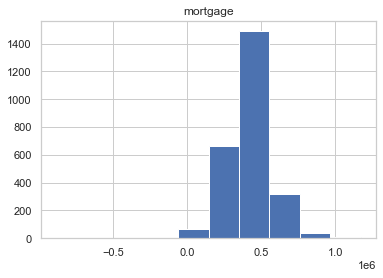

In [102]:
synthetic_mortgages_df.hist('mortgage')

<ipython-input-103-a79cde1f0dbe>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned['roi'] = (cleaned['earnings_per_mo'] * 12) / cleaned['mortgage']


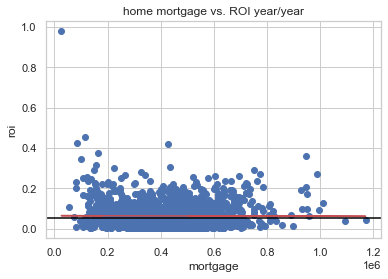

In [103]:
#Parameterized cell to let you scatter two variables from merged_numerics
cleaned = synthetic_mortgages_df.loc[(synthetic_mortgages_df['roi'] < 1) & (synthetic_mortgages_df['roi'] > 0)]
#roi is a feature that lets you measure the performance of an airbnb listing. A common benchmark is 5% ROI.
cleaned['roi'] = (cleaned['earnings_per_mo'] * 12) / cleaned['mortgage']
#merged_numerics = merged_numerics.drop(columns = 'avg_earnings')
fig, ax = plt.subplots()
x = cleaned['mortgage']
y = cleaned['roi']
m,b = np.polyfit(x = x, y = y, deg = 1)
plt.scatter(x,y)
plt.xlabel(x.name)
plt.ylabel(y.name)
plt.title('home {} vs. ROI year/year'.format(x.name))
plt.plot(x,x*m+b, c= 'r')
plt.axhline(.05, c = 'black');

In [118]:
#This cell taken from Dave Fisher-Hickey from Kaggle guide: How to: Folium for maps, heatmaps & time data
#https://www.kaggle.com/code/daveianhickey/how-to-folium-for-maps-heatmaps-time-data/notebook
df_acc = synthetic_mortgages_df.join(bnb_listings[['latitude','longitude']])
df_acc = df_acc.loc[df_acc['roi'] > 0.07]

from folium import plugins
from folium.plugins import HeatMap


map_hooray = folium.Map(location=[df_acc['latitude'].mean(), df_acc['longitude'].mean()],
                    zoom_start = 12) 

# Ensure you're handing it floats
#df_acc['Latitude'] = df_acc['Latitude'].astype(float)
#df_acc['Longitude'] = df_acc['Longitude'].astype(float)

# Filter the DF for rows, then columns, then remove NaNs
heat_df = df_acc[['latitude', 'longitude']]
heat_df = heat_df.dropna(axis=0, subset=['latitude','longitude'])

# List comprehension to make out list of lists
heat_data = [[row['latitude'],row['longitude']] for index, row in heat_df.iterrows()]

# Plot it on the map
HeatMap(heat_data, radius=15).add_to(map_hooray)

# Display the map
map_hooray;

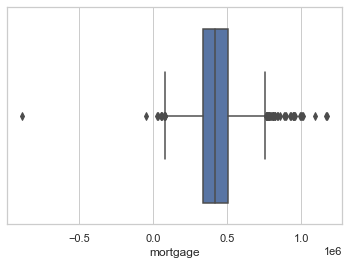

In [105]:
import seaborn as sns
sns.set_theme(style="whitegrid")

ax = sns.boxplot(x=synthetic_mortgages_df['mortgage'])

In [106]:

drop = []
for each_column in synthetic_mortgages_df:
    remove = list(lower_outliers(synthetic_mortgages_df['mortgage'],0.005))
    for item in remove:
        drop.append(item)
synthetic_mortgages_df = synthetic_mortgages_df.drop(labels = (np.array(drop)),axis = 0)

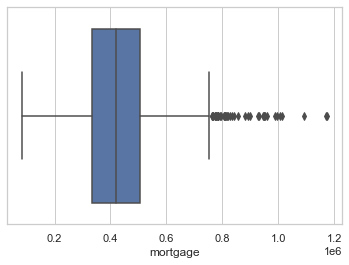

In [107]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=synthetic_mortgages_df['mortgage'])

In [110]:
drop = []
for each_column in synthetic_mortgages_df:
    remove = list(outliers(synthetic_mortgages_df['mortgage'],0.985))
    for item in remove:
        drop.append(item)
synthetic_mortgages_df = synthetic_mortgages_df.drop(labels = (np.array(drop)),axis = 0)

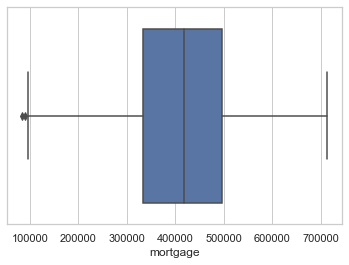

In [111]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=synthetic_mortgages_df['mortgage'])

In [117]:
import statsmodels.api as sm

In [148]:
drop_list = ['host_listings_count', 'roi',
 'accommodates',
'guests_included',
 'minimum_nights',
 'maximum_nights',
 'availability_30',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_communication',
 'review_scores_location',
 'reviews_per_month',
'property_type_Bed & Breakfast',
 'property_type_Bungalow',
 'property_type_Cabin',
 'property_type_Camper/RV',
 'property_type_Condominium',
 'property_type_House',
 'property_type_Loft',
 'property_type_Other',
 'property_type_Tent',
 'property_type_Townhouse',
 'property_type_Yurt',
 'room_type_Private room',
 'room_type_Shared room',
 'neighbourhood_cleansed_Alki',
'neighbourhood_cleansed_Atlantic',
 'neighbourhood_cleansed_Bitter Lake',
 'neighbourhood_cleansed_Briarcliff',
 'neighbourhood_cleansed_Brighton',
 'neighbourhood_cleansed_Broadview',
 'neighbourhood_cleansed_Broadway',
 'neighbourhood_cleansed_Bryant',
 'neighbourhood_cleansed_Columbia City',
 'neighbourhood_cleansed_Crown Hill',
 'neighbourhood_cleansed_Dunlap',
 'neighbourhood_cleansed_East Queen Anne',
 'neighbourhood_cleansed_Eastlake',
 'neighbourhood_cleansed_Fairmount Park',
 'neighbourhood_cleansed_Fauntleroy',
 'neighbourhood_cleansed_Fremont',
 'neighbourhood_cleansed_Gatewood',
'neighbourhood_cleansed_Genesee',
 'neighbourhood_cleansed_Georgetown',
 'neighbourhood_cleansed_Green Lake',
 'neighbourhood_cleansed_Greenwood',
 'neighbourhood_cleansed_Haller Lake',
 'neighbourhood_cleansed_Harrison/Denny-Blaine',
 'neighbourhood_cleansed_High Point',
 'neighbourhood_cleansed_Highland Park',
 'neighbourhood_cleansed_Holly Park',
 'neighbourhood_cleansed_Lawton Park',
 'neighbourhood_cleansed_Leschi',
 'neighbourhood_cleansed_Lower Queen Anne',
 'neighbourhood_cleansed_Loyal Heights',
'neighbourhood_cleansed_Madison Park',
 'neighbourhood_cleansed_Madrona',
 'neighbourhood_cleansed_Mann',
 'neighbourhood_cleansed_Maple Leaf',
 'neighbourhood_cleansed_Matthews Beach',
 'neighbourhood_cleansed_Mid-Beacon Hill',
 'neighbourhood_cleansed_Minor',
 'neighbourhood_cleansed_Montlake',
 'neighbourhood_cleansed_Mount Baker',
 'neighbourhood_cleansed_North Admiral',
 'neighbourhood_cleansed_North Beach/Blue Ridge',
 'neighbourhood_cleansed_North Beacon Hill',
 'neighbourhood_cleansed_North College Park',
 'neighbourhood_cleansed_North Delridge',
 'neighbourhood_cleansed_North Queen Anne',
 'neighbourhood_cleansed_Olympic Hills',
'neighbourhood_cleansed_Phinney Ridge',
 'neighbourhood_cleansed_Pinehurst',
 'neighbourhood_cleansed_Portage Bay',
 'neighbourhood_cleansed_Rainier Beach',
 'neighbourhood_cleansed_Ravenna',
 'neighbourhood_cleansed_Roosevelt',
 'neighbourhood_cleansed_Seaview',
 'neighbourhood_cleansed_Seward Park',
 'neighbourhood_cleansed_South Delridge',
 'neighbourhood_cleansed_South Park',
 'neighbourhood_cleansed_Southeast Magnolia',
 'neighbourhood_cleansed_Stevens',
 'neighbourhood_cleansed_Sunset Hill',
 'neighbourhood_cleansed_University District',
 'neighbourhood_cleansed_Victory Heights',
 'neighbourhood_cleansed_Wallingford',
 'neighbourhood_cleansed_West Queen Anne',
 'neighbourhood_cleansed_West Woodland',
 'neighbourhood_cleansed_Whittier Heights',
 'neighbourhood_cleansed_Windermere', 'earnings_per_mo', 'price']
y = synthetic_mortgages_df['roi']
X = sm.add_constant(synthetic_mortgages_df.drop(columns = drop_list))
results = sm.OLS(y, X).fit()
lr = LinearRegression()

In [149]:
par = results.params
par

const            4.899572e-02
bedrooms         2.135486e-02
bathrooms        2.672408e-03
zipcode_98103   -1.310320e-02
zipcode_98105   -2.387471e-02
zipcode_98106    9.113345e-03
zipcode_98107   -1.049973e-02
zipcode_98108   -6.623350e-03
zipcode_98109    4.177223e-03
zipcode_98112   -8.269168e-03
zipcode_98115   -7.718306e-03
zipcode_98116   -8.674366e-03
zipcode_98117   -1.699720e-02
zipcode_98118   -1.344944e-02
zipcode_98119   -2.451093e-03
zipcode_98122   -4.026693e-03
zipcode_98125   -1.302889e-02
zipcode_98126   -3.002400e-02
zipcode_98133    4.332340e-03
zipcode_98136    1.026231e-02
zipcode_98144   -5.488308e-03
zipcode_98177   -3.699833e-03
zipcode_98178   -5.590630e-02
zipcode_98199   -4.011507e-02
mortgage        -6.136458e-08
dtype: float64

In [150]:
results.rsquared

0.10634394619189902

In [151]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    roi   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     12.31
Date:                Wed, 30 Mar 2022   Prob (F-statistic):           1.45e-45
Time:                        14:59:23   Log-Likelihood:                 3871.7
No. Observations:                2508   AIC:                            -7693.
Df Residuals:                    2483   BIC:                            -7548.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0490      0.006      8.046      0.000       0.037       0.061
bedrooms          0.0214      0.002     11.662      0.000       0.018       0.025
bathrooms         0.0027      0.002      1.169      0.242      -0.002       0.007
zipcode_98103    -0.0131      0.004     -3.018      0.003      -0.022      -0.005
zipcode_98105    -0.0239      0.005     -4.555      0.000      -0.034      -0.014
zipcode_98106     0.0091      0.010      0.952      0.341      -0.010       0.028
zipcode_98107    -0.0105      0.005     -1.952      0.051      -0.021    4.84e-05
zipcode_98108    -0.0066      0.009     -0.750      0.453      -0.024       0.011
zipcode_98109     0.0042      0.006      0.733      0.464      -0.007       0.015
zipcode_98112    -0.0083      0.006     -1.446      0.148      -0.019       0.003
zipcode_98115    -0.0077      0.006     -1.348      0.178      -0.019       0.004
zipcode_98116    -0.0087      0.006     -1.335      0.182      -0.021       0.004
zipcode_98117    -0.0170      0.006     -3.066      0.002      -0.028      -0.006
zipcode_98118    -0.0134      0.006     -2.295      0.022      -0.025      -0.002
zipcode_98119    -0.0025      0.006     -0.388      0.698      -0.015       0.010
zipcode_98122    -0.0040      0.004     -0.935      0.350      -0.012       0.004
zipcode_98125    -0.0130      0.009     -1.509      0.131      -0.030       0.004
zipcode_98126    -0.0300      0.009     -3.519      0.000      -0.047      -0.013
zipcode_98133     0.0043      0.010      0.436      0.663      -0.015       0.024
zipcode_98136     0.0103      0.010      1.060      0.289      -0.009       0.029
zipcode_98144    -0.0055      0.006     -0.949      0.343      -0.017       0.006
zipcode_98177    -0.0037      0.014     -0.259      0.796      -0.032       0.024
zipcode_98178    -0.0559      0.030     -1.836      0.066      -0.116       0.004
zipcode_98199    -0.0401      0.009     -4.494      0.000      -0.058      -0.023
mortgage      -6.136e-08   1.42e-08     -4.330      0.000   -8.92e-08   -3.36e-08
==============================================================================
Omnibus:                      799.560   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3136.026
Skew:                           1.524   Prob(JB):                         0.00
Kurtosis:                       7.552   Cond. No.                     1.27e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.27e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

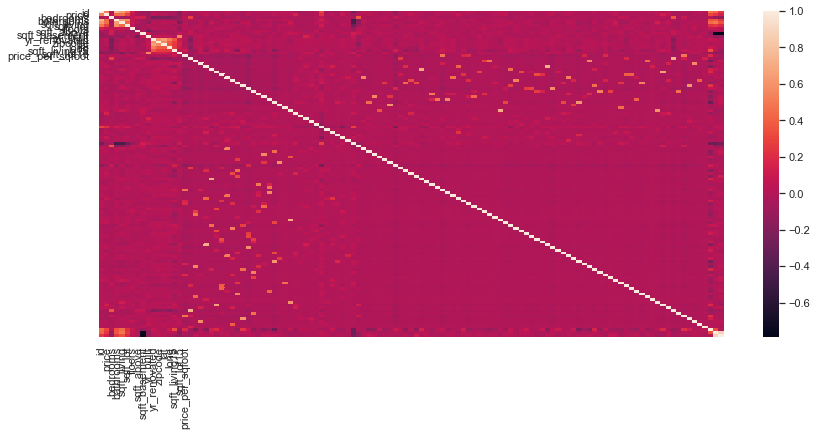

In [152]:
#Correlation matrix
plt.figure(figsize=(14,6))
Var_Corr_1 = synthetic_mortgages_df.corr()
# plot the heatmap and annotation on it
sns.heatmap(Var_Corr_1, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=False);

In [ ]:
nominal_cols = ['zipcode', 'property_type','room_type','neighbourhood_cleansed']
airbnb_training_set_model = pd.get_dummies(airbnb_training_set,columns=nominal_cols,drop_first=True)
airbnb_training_set_model.shape


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
MAE = round(mean_absolute_error(y_pred, y_test),2)
score = round(lr.score(X_train, y_train),2)
print('R^2 value: {}, absolute mean error: {}'.format(score,MAE))